# Rb87 J-M Polarizability Calcs
using formulas from Mark's notes

## Dynamic polarizability
$\alpha_0$: scalar shift. no dependence on light polarization <br/>
$\alpha_1$: vector shift. zero for linear light or $j_a=0$ <br/>
$\alpha_2$: tensor shift. non-zero for $j_a\geq1$ <br/>

In [1]:
#### libraries
from numpy import *
import matplotlib.pyplot as plt
from arc import *
from sympy.physics.wigner import wigner_6j,wigner_3j,clebsch_gordan

#### local files
from physconsts import *
from rbconsts import *
from amophys import *
from simfuncs import *

s = 0.5 # electron spin to be used throughout the notebook

In [2]:
def alpha0_jm(state, omega, nbounds, atom, I, printterms=False):
    """
    Returns the scalar polarizability for a fine structure level
    
    Args:
        'state': list of quantum numbers n,l,j
        'omega': angular frequency of the applied field in inverse seconds
        'nbounds': is a list or two-tuple of the lower and uppper n values to use in the perturbative sum, e.g.
            [4,11] will start at 4 and end at 10
        'atom': an Atom object from the Alkali Rydberg Calculator module
        'I': the nuclear spin
    Returns:
        'alpha0': scalar polarizability in S.I. units.
    """
    alpha0 = 0
    terms = 0
    
    n_a, l_a, j_a = state
    #todo assert that n_a, l_a are type int

    n_min, n_max = nbounds

    # program:
    # - loop over levels from nmin to nmax
    #  - loop over l
    #   - loop over j

    for n_b in range(n_min, n_max):
        for l_b in range(n_b): # runs through n_b - 1, inclusive
            for j_b in j3_from_j1j2(s, l_b): 

                # triangle and dipole-allowed conditions
                if abs(j_b - j_a) <= 1 and abs(l_b - l_a) == 1: 
                    w_ba = 2*pi*(eVToGHz(atom.getEnergy(n_b, l_b, j_b) \
                                        - atom.getEnergy(n_a, l_a, j_a))*1e9)
                    matelem = abs(atom.getReducedMatrixElementJ(n_a, l_a, j_a, n_b, l_b, j_b)*ee*a0)
#                     print(f"< n={n_a}, l={l_a}, j={j_a} | x | n'={n_b}, l'={l_b}, j'={j_b} >")
                    alpha0 += (2/(3*hbar*(2*j_a+1)))* \
                                    w_ba*matelem**2/(w_ba**2 - omega**2) # Mark's Notes 9.11a
                    terms += 1
                    if printterms:
                        print(f"alpha0 ~= {alpha0/(4*pi*e0*1e-30)} [Ang.^3], {terms} terms in sum")

                    
    return alpha0

## Finite sum for $\alpha_0(\omega)$ - J-M basis
agrees within a few percent of values given here: https://wiki.physics.wisc.edu/saffmanwiki/Literature/Rb

In [3]:
# our atom
rb = Rubidium87()

# the 5s1/2 state
n_a = 5
j_a = 1/2 
l_a = 0
# w_a = 2*pi*level_a["E"]*1e9 # [rad/s], wrt zeropoint at 5s1/2 COM

l_b = l_a + 1 # for dipole-allowed transitions with l_a = 0
j_b_list = [ l_b - .5, l_b + .5]
n_min = 4
n_max = 20 # exclusive max

f_laser = c/.76e-6

In [4]:
## reproduce the table on the wiki
state_a = [5,0,1/2]

wavelengths = array([0.76,.765,.77,.775,.976,1.01,1.04,1.064])*1e-6

# for i in range(pts):
for w in wavelengths:
    alpha = alpha0_jm(state=state_a, omega=2*pi*c/w, nbounds=[n_min,n_max], atom=rb, I=3/2, printterms=False)/(4*pi*e0*1e-30)
    print(f'lambda={w:0.3} [um], a0={alpha} [Ang^3]')

lambda=7.6e-07 [um], a0=-727.4740649497686 [Ang^3]
lambda=7.65e-07 [um], a0=-947.8280530105769 [Ang^3]
lambda=7.7e-07 [um], a0=-1366.526662018439 [Ang^3]
lambda=7.75e-07 [um], a0=-2526.463696898382 [Ang^3]
lambda=9.76e-07 [um], a0=126.2513997508997 [Ang^3]
lambda=1.01e-06 [um], a0=112.17985312660149 [Ang^3]
lambda=1.04e-06 [um], a0=102.93035590938844 [Ang^3]
lambda=1.06e-06 [um], a0=96.98998898422641 [Ang^3]


In [74]:
# Scalar shift for 5S1/2, 5P1/2

states = [[5,0,1/2],[5,1,1/2],[5,1,3/2],[6,1,1/2],[6,1,3/2]]

wavelengths = concatenate((linspace(0.8,1,200),linspace(1,1.2,400)))*1e-6
# wavelengths = linspace(0.85,1.2,pts)
alpha0_arr = empty((len(states),len(wavelengths)),float)
for i,state_a in enumerate(states):
    alpha0_arr[i,:] = array([alpha0_jm(state=state_a, omega=2*pi*c/w, nbounds=[n_min,n_max], 
                                atom=rb, I=3/2, printterms=False)/(4*pi*e0*1e-30) for w in wavelengths])

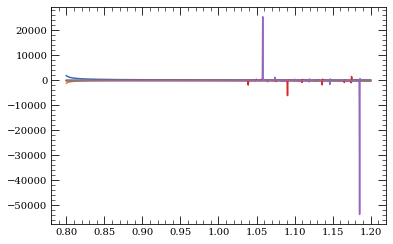

In [75]:
for i in range(len(states)):
    plt.plot(wavelengths*1e6,alpha0_arr[i])

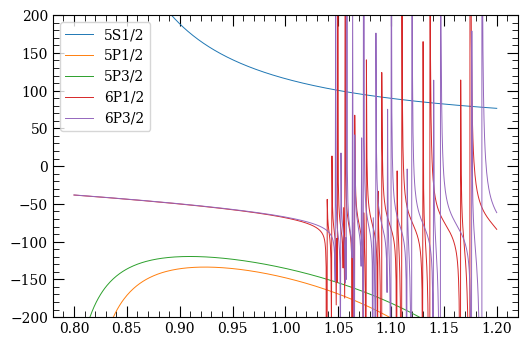

In [80]:
# zoom in
fig,ax = plt.subplots(dpi=100)
for i,label in enumerate(['5S1/2','5P1/2','5P3/2','6P1/2','6P3/2']):
    ax.plot(wavelengths*1e6,alpha0_arr[i],label=label,linewidth='0.7')
ax.set_ylim((-200,200))
ax.legend()

In [61]:
# fname = './solns/alpha0_jm_Rb87_5s_5p_750_to_1100nm.csv'
# data = [wavelengths,alpha0_arr[0],alpha0_arr[1],alpha0_arr[2]]
# soln_to_csv(fname,data,labels=['wavelength [m]','5S1/2','5P1/2','5P3/2'])

wrote data to ./solns/alpha0_jm_Rb87_5s_5p_750_to_1100nm.csv


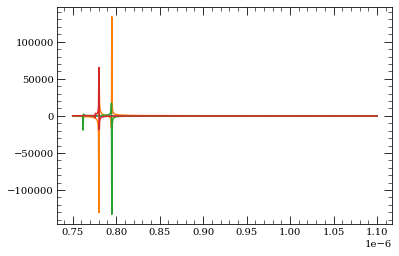

In [63]:
data, labels = soln_from_csv(fname)
wvl = data[0]
for d in data[0:]:
    plt.plot(wvl,d)

In [6]:
states = array([[5,0,1/2], [5,1,1/2]])

In [7]:
states.shape

(2, 3)

In [20]:
state_a = [5,0,1/2]

wmin = 0.8
wmax = 1.064
steps = 40
wavelengths = linspace(wmin,wmax,steps)*1e-6
alpha_pts = zeros(len(wavelengths))

# for i in range(pts):
for i,w in enumerate(wavelengths):
    alpha_pts[i] = alpha0_jm(state=state_a, omega=2*pi*c/w, nbounds=[n_min,n_max], atom=rb, I=3/2, printterms=False)/(4*pi*e0*1e-30)
    print(f'lambda={w:0.3} [um], a0={alpha_pts[i]} [Ang^3]')
    
alpha_pts_SI = alpha_pts*4*pi*e0*1e-30

lambda=8e-07 [um], a0=1838.6930092089565 [Ang^3]
lambda=8.07e-07 [um], a0=989.6638150137601 [Ang^3]
lambda=8.14e-07 [um], a0=711.1955054867217 [Ang^3]
lambda=8.2e-07 [um], a0=563.9604226179368 [Ang^3]
lambda=8.27e-07 [um], a0=470.9646775970992 [Ang^3]
lambda=8.34e-07 [um], a0=406.3349143416272 [Ang^3]
lambda=8.41e-07 [um], a0=358.6068527428724 [Ang^3]
lambda=8.47e-07 [um], a0=321.8327420458348 [Ang^3]
lambda=8.54e-07 [um], a0=292.59106796164565 [Ang^3]
lambda=8.61e-07 [um], a0=268.7634701057003 [Ang^3]
lambda=8.68e-07 [um], a0=248.96386759734014 [Ang^3]
lambda=8.74e-07 [um], a0=232.24521761126007 [Ang^3]
lambda=8.81e-07 [um], a0=217.93747112162907 [Ang^3]
lambda=8.88e-07 [um], a0=205.55270294223803 [Ang^3]
lambda=8.95e-07 [um], a0=194.7268989801543 [Ang^3]
lambda=9.02e-07 [um], a0=185.18281547701957 [Ang^3]
lambda=9.08e-07 [um], a0=176.70548792379455 [Ang^3]
lambda=9.15e-07 [um], a0=169.1256179368576 [Ang^3]
lambda=9.22e-07 [um], a0=162.30802385019587 [Ang^3]
lambda=9.29e-07 [um], a0=1

In [21]:
fname = f'five_s_onehalf_dynamic_alpha0_{wmin}um_to_{wmax}um_{steps}steps.csv'
soln_to_csv(fname, 
            [wavelengths, alpha_pts, alpha_pts_SI], 
            ['lambda [m]','alpha0 [Ang^3]', 'alpha0 [S.I.]']
           )

wrote data to five_s_onehalf_dynamic_alpha0_0.8um_to_1.064um_40steps.csv


In [7]:
## differential Stark shift at 532 for blue-detuned trap array in Yavuz lab
state_a = [5,0,1/2]
w = .532e-6

alpha5s = alpha0_jm(state=state_a, omega=2*pi*c/w, nbounds=[n_min,n_max], atom=rb, I=3/2, printterms=False)/(4*pi*e0*1e-30)
print(f'lambda={w:0.3} [m], a0={alpha5s} [Ang^3]')

state_a = [5,1,3/2]
alpha5p = alpha0_jm(state=state_a, omega=2*pi*c/w, nbounds=[n_min,n_max], atom=rb, I=3/2, printterms=False)/(4*pi*e0*1e-30)
print(f'lambda={w:0.3} [m], a0={alpha5p} [Ang^3]')

lambda=5.32e-07 [m], a0=-42.47023239863653 [Ang^3]
lambda=5.32e-07 [m], a0=-10.709205908290864 [Ang^3]


In [28]:
alpha5sSI = alpha5s*4*pi*e0*1e-30
alpha5pSI = alpha5p*4*pi*e0*1e-30
I0 = 4/(4e-5)**2 # 4 W per 40 micron sq area
# I0 = 4/(4.3*8e-6)**2

h = 2*pi*hbar
-1e-6*(1/4)*2*I0*(alpha5pSI - alpha5sSI)/(h*e0*c)

-2.5115260202806233

In [17]:
alpha5sSI - alpha5pSI, alpha5s - alpha5p 

(-3.533890791430109e-39, -31.76102649034567)

### read in csv files saved previously

In [11]:
data,labels = soln_from_csv('five_s_onehalf_dynamic_alpha0_0.8um_to_1.064um_40steps.csv')
lmbda_pts = data[0].astype(float)
alpha0_SI_pts = data[2].astype(float)

C:\Users\prest\AppData\Local\Temp\ipykernel_13260\3544286961.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  lmbda_pts = data[0].astype(float)
C:\Users\prest\AppData\Local\Temp\ipykernel_13260\3544286961.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  alpha0_SI_pts = data[2].astype(float)


In [13]:
alpha0_SI = lambda lmbda: interp(lmbda, lmbda_pts, alpha0_SI_pts)

In [18]:
lmbda_pts
alpha0_SI_pts[8]

3.2555146825580685e-38

In [27]:
TFORT = 1e-3 # K
w0 = 0.7e-6 # m
P = kB*TFORT*pi*w0**2/alpha0_SI(8.52e-7)
print(f"Power for T={TFORT*1**3}mK = {P*1**3} mW")

Power for T=0.001mK = 0.6327474769630749 mW


## Finite sum for $\alpha_1(\omega)$ - J-M basis
check this with values from Mark here https://wiki.physics.wisc.edu/saffmanwiki/Literature/Rb

In [36]:
# our atom
rb = Rubidium87()

# the 5p3/2 state
level_a = hf_levels[6] # deprecated
n_a = level_a["n"]
j_a = level_a["J"] 
l_a = level_a["L"]
# w_a = 2*pi*level_a["E"]*1e9 # [rad/s], wrt zeropoint at 5s1/2 COM

l_b = l_a + 1 # for dipole-allowed transitions with l_a = 0
j_b_list = [ l_b - .5, l_b + .5]
n_min = 5
n_max = 11 # exclusive max

f780A = rb.getTransitionFrequency(5,0,1/2,5,1,3/2) + (-hf_levels[1]["nu"] + hf_levels[6]["nu"] - 2.1e9)

# l_arr = [rb.getTransitionWavelength(
#             n_a,l_a,j_a,n_b,l_b,j_b
#         )] # 1.064e-6] # selected wavelengths
w_arr = array([
        2*pi*f780A
    ]) #2*pi*c/l for l in l_arr]) # ang. freqs
mF_a = 0
q = 1
mF_b = mF_a + q

pts = len(w_arr)
alpha1 = zeros(pts) 
terms = 0

for i in range(pts):
    for n_b in range(n_min, n_max):
        for l_b in range(n_b): # runs through n_b - 1, inclusive
            for j_b in j_b_list: 
                
                # triangle and dipole-allowed conditions
                if abs(j_b - j_a) <= 1 and abs(l_b - l_a) == 1: 
                    w_ba = 2*pi*(eVToGHz(rb.getEnergy(n_b, l_b, j_b) \
                                        - rb.getEnergy(n_a, l_a, j_a))*1e9)
                    matelem = abs(rb.getReducedMatrixElementJ(n_a, l_a, j_a, n_b, l_b, j_b)*ee*a0)
#                     print(f"< n={n_a}, l={l_a}, j={j_a} | x | n'={n_b}, l'={l_b}, j'={j_b} >")
                    alpha0[i] += (2/(3*hbar*(2*j_a+1)))* \
                                    w_ba*matelem**2/(w_ba**2 - w_arr[i]**2) # Mark's Notes 9.11a
                    terms += 1
                    print(f"alpha0 ~= {alpha0[i]/(4*pi*e0*1e-30)} [Ang.^3], {terms} terms in sum")
# alpha as printed is in cubic Angstroms. as it stands, I don't remember how to make it true S.I.
#A^3 to cgs: 1e-30 -> 1e-6; cgs to a.u.: EH/(ee*a0)**2

NameError: name 'hf_levels' is not defined